In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
import sys
sys.path.insert(0,'/content/gdrive/MyDrive/PROJECT')

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from myDataPreprocessing import myPreprocessor
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, initializers
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [30]:
DATA_DIR = "/content/gdrive/MyDrive/PROJECT/DATASET/UNSW-NB15/"
training_fname= "UNSW_NB15_training-set.csv"
testing_fname= "UNSW_NB15_testing-set.csv"

In [31]:
df1 = pd.read_csv(DATA_DIR + training_fname)
df2 =  pd.read_csv(DATA_DIR  + testing_fname)
df_ori = df1.append(df2, ignore_index=True)

In [32]:
df = df_ori.copy()
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
257669,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
257670,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
257671,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [33]:
def Remove_dump_values(data, cols):
    for col in cols:
        data[col] = np.where(data[col] == '-', np.nan, data[col])
    return data

In [34]:
cols = df.columns
df = Remove_dump_values(df, cols)
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1.0,0.121478,tcp,NaN,FIN,6.0,4.0,258.0,172.0,74.087490,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Normal,0.0
1,2.0,0.649902,tcp,NaN,FIN,14.0,38.0,734.0,42014.0,78.473372,...,1.0,2.0,0.0,0.0,0.0,1.0,6.0,0.0,Normal,0.0
2,3.0,1.623129,tcp,NaN,FIN,8.0,16.0,364.0,13186.0,14.170161,...,1.0,3.0,0.0,0.0,0.0,2.0,6.0,0.0,Normal,0.0
3,4.0,1.681642,tcp,ftp,FIN,12.0,12.0,628.0,770.0,13.677108,...,1.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,Normal,0.0
4,5.0,0.449454,tcp,NaN,FIN,10.0,6.0,534.0,268.0,33.373826,...,1.0,40.0,0.0,0.0,0.0,2.0,39.0,0.0,Normal,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,82328.0,0.000005,udp,NaN,INT,2.0,0.0,104.0,0.0,200000.005100,...,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,Normal,0.0
257669,82329.0,1.106101,tcp,NaN,FIN,20.0,8.0,18062.0,354.0,24.410067,...,1.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,Normal,0.0
257670,82330.0,0.000000,arp,NaN,INT,1.0,0.0,46.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,Normal,0.0
257671,82331.0,0.000000,arp,NaN,INT,1.0,0.0,46.0,0.0,0.000000,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,Normal,0.0


In [35]:
df.isnull().sum()

id                        0
dur                       0
proto                     0
service              141321
state                     0
spkts                     0
dpkts                     0
sbytes                    0
dbytes                    0
rate                      0
sttl                      0
dttl                      0
sload                     0
dload                     0
sloss                     0
dloss                     0
sinpkt                    0
dinpkt                    0
sjit                      0
djit                      0
swin                      0
stcpb                     0
dtcpb                     0
dwin                      0
tcprtt                    0
synack                    0
ackdat                    0
smean                     0
dmean                     0
trans_depth               0
response_body_len         0
ct_srv_src                0
ct_state_ttl              0
ct_dst_ltm                0
ct_src_dport_ltm          0
ct_dst_sport_ltm    

In [36]:
# Drop id, label and service
df.drop(['id','label','service'], axis=1, inplace = True)

In [37]:
df =df.loc[df['attack_cat'] != 'Normal']
df

,dur,proto,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
47911,0.000009,ddp,INT,2.0,0.0,200.0,0.0,111111.107200,254.0,0.0,...,1.0,1.0,4.0,0.0,0.0,0.0,2.0,4.0,0.0,Backdoor
47912,0.000009,ipv6-frag,INT,2.0,0.0,200.0,0.0,111111.107200,254.0,0.0,...,2.0,2.0,7.0,0.0,0.0,0.0,2.0,7.0,0.0,Backdoor
47913,0.000009,cftp,INT,2.0,0.0,200.0,0.0,111111.107200,254.0,0.0,...,1.0,1.0,6.0,0.0,0.0,0.0,1.0,6.0,0.0,Backdoor
47914,0.000003,wsn,INT,2.0,0.0,200.0,0.0,333333.321500,254.0,0.0,...,2.0,2.0,7.0,0.0,0.0,0.0,2.0,6.0,0.0,Backdoor
47915,0.000008,pvp,INT,2.0,0.0,200.0,0.0,125000.000300,254.0,0.0,...,1.0,1.0,4.0,0.0,0.0,0.0,11.0,4.0,0.0,Backdoor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241188,0.000012,udp,INT,2.0,0.0,1510.0,0.0,83333.330390,254.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,Fuzzers
241189,20.542910,udp,INT,4.0,0.0,1216.0,0.0,0.146036,254.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,0.0,Fuzzers
241190,20.542910,udp,INT,4.0,0.0,1216.0,0.0,0.146036,254.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,0.0,Fuzzers
241191,0.627022,tcp,FIN,10.0,6.0,590.0,268.0,23.922605,254.0,252.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5.0,0.0,Fuzzers


In [38]:
df['attack_cat'].value_counts()

Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

## Data Visualization

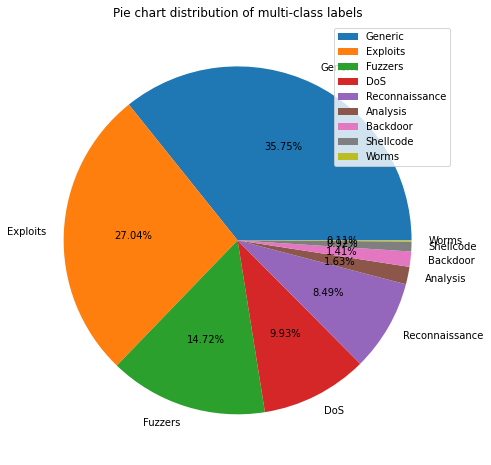

In [39]:
plt.figure(figsize=(8,8))
plt.pie(df.attack_cat.value_counts(),labels = ['Generic','Exploits','Fuzzers','DoS','Reconnaissance','Analysis','Backdoor','Shellcode','Worms'],
        autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend(loc='best')
plt.savefig('/content/gdrive/MyDrive/PROJECT/plots/Pie_chart_multi.png')
plt.show()

In [40]:
x, y = myPreprocessor(df, 'mean', 'attack_cat')

Feature 'proto' has 129 unique categories
Feature 'state' has 7 unique categories
Feature 'attack_cat' has 9 unique categories


/content/gdrive/MyDrive/PROJECT/myDataPreprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name[i]]= label_encoder.fit_transform(df[name[i]])


In [41]:
y.unique()

array([1, 0, 4, 7, 6, 3, 2, 8, 5])

In [42]:
n_classes = len(y.unique())
n_classes

9

In [43]:
x.head()

,dur,proto,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,1.500012e-07,0.148438,0.666667,0.000094,0.0,0.000012,0.0,0.111111,0.996078,0.0,...,0.000000,0.000000,0.000000,0.046875,0.0,0.0,0.0,0.016949,0.049180,0.0
1,1.500012e-07,0.390625,0.666667,0.000094,0.0,0.000012,0.0,0.111111,0.996078,0.0,...,0.017241,0.017241,0.027027,0.093750,0.0,0.0,0.0,0.016949,0.098361,0.0
2,1.500012e-07,0.085938,0.666667,0.000094,0.0,0.000012,0.0,0.111111,0.996078,0.0,...,0.000000,0.000000,0.000000,0.078125,0.0,0.0,0.0,0.000000,0.081967,0.0
3,5.000039e-08,0.968750,0.666667,0.000094,0.0,0.000012,0.0,0.333333,0.996078,0.0,...,0.017241,0.017241,0.027027,0.093750,0.0,0.0,0.0,0.016949,0.081967,0.0
4,1.333344e-07,0.656250,0.666667,0.000094,0.0,0.000012,0.0,0.125000,0.996078,0.0,...,0.000000,0.000000,0.000000,0.046875,0.0,0.0,0.0,0.169492,0.049180,0.0


In [44]:
x_array = np.array(x)
y_array = np.array(y)

In [45]:
x_3d =np.expand_dims(x_array, axis =2)

In [46]:
x_3d[2:]

array([[[1.50001183e-07],
        [8.59375000e-02],
        [6.66666667e-01],
        ...,
        [0.00000000e+00],
        [8.19672131e-02],
        [0.00000000e+00]],

       [[5.00003942e-08],
        [9.68750000e-01],
        [6.66666667e-01],
        ...,
        [1.69491525e-02],
        [8.19672131e-02],
        [0.00000000e+00]],

       [[1.33334384e-07],
        [6.56250000e-01],
        [6.66666667e-01],
        ...,
        [1.69491525e-01],
        [4.91803279e-02],
        [0.00000000e+00]],

       ...,

       [[3.42384532e-01],
        [8.98437500e-01],
        [6.66666667e-01],
        ...,
        [0.00000000e+00],
        [8.19672131e-02],
        [0.00000000e+00]],

       [[1.04504491e-02],
        [8.51562500e-01],
        [5.00000000e-01],
        ...,
        [0.00000000e+00],
        [6.55737705e-02],
        [0.00000000e+00]],

       [[5.65159455e-03],
        [8.51562500e-01],
        [5.00000000e-01],
        ...,
        [1.69491525e-02],
        [4.9180

In [47]:
x_3d.shape, y_array.shape

((164673, 41, 1), (164673,))

In [48]:
unique, counts = np.unique(y_array, return_counts=True)

dict(zip(unique, counts))

{0: 2677,
 1: 2329,
 2: 16353,
 3: 44525,
 4: 24246,
 5: 58871,
 6: 13987,
 7: 1511,
 8: 174}

## Model

In [53]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='relu',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='relu',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
     
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 41, 32)            128       
                                                                 
 conv1d_9 (Conv1D)           (None, 41, 32)            3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 20, 64)           

## Splitting K-Folds

In [54]:
# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

## Model Fitting

In [55]:
n_epochs = 15
batch_size = 128
verbosity = 1

# Define per-fold score containers
model_history = []
clr = []
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train],
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=verbosity,
              validation_split=0.2,
              callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    #y_preds1 = np.round(y_preds)
    y_preds_arg=np.argmax(y_preds, axis=1)

    print(y_array[test].shape, y_preds_arg.shape)

    clr = classification_report(y_array[test], y_preds_arg, target_names=['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'])
    cm= confusion_matrix(y_array[test],y_preds_arg)
    accuracy = accuracy_score(y_array[test], y_preds_arg)
    recall = recall_score(y_array[test], y_preds_arg, average='weighted')
    precision = precision_score(y_array[test], y_preds_arg, average='weighted')
    f1 = f1_score(y_array[test], y_preds_arg, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/15
858/858 [==============================] - 8s 8ms/step - loss: 0.7354 - accuracy: 0.7314 - val_loss: 0.6892 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 2/15
858/858 [==============================] - 7s 8ms/step - loss: 0.6383 - accuracy: 0.7610 - val_loss: 0.7014 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 3/15
858/858 [==============================] - 6s 8ms/step - loss: 0.6158 - accuracy: 0.7673 - val_loss: 0.5970 - val_accuracy: 0.8035 - lr: 0.0010
Epoch 4/15
858/858 [==============================] - 6s 8ms/step - loss: 0.6047 - accuracy: 0.7703 - val_loss: 0.5801 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 5/15
858/858 [==============================] - 6s 8ms/step - loss: 0.5941 - accuracy: 0.7719 - val_loss: 0.5724 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 6/15
858/858 [==============================] - 6s 8ms/step - loss: 0.5841 - accuracy: 0.7750 - val_loss: 0.5938 - val_acc

## The FINAL Average Scores

In [56]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 79.45420097646287 % - Loss: 0.5461919903755188 - Recall: 0.7945420097646287 - Precison: 0.8115674634875643 - f1_score: 0.7581828281454819
------------------------------------------------------------------------
> Fold 2 - Accuracy: 80.35050644902718 % - Loss: 0.5217476487159729 - Recall: 0.8035050644902718 - Precison: 0.8072797073332594 - f1_score: 0.782397272912812
------------------------------------------------------------------------
> Fold 3 - Accuracy: 80.53996939444727 % - Loss: 0.5143886804580688 - Recall: 0.8053996939444727 - Precison: 0.81632630885715 - f1_score: 0.7832270184554879
------------------------------------------------------------------------
> Fold 4 - Accuracy: 80.71415558389506 % - Loss: 0.4998982548713684 - Recall: 0.8071415558389506 - Precison: 0.8174124314888856 - f1_score: 0.7843

## Plotting Graph

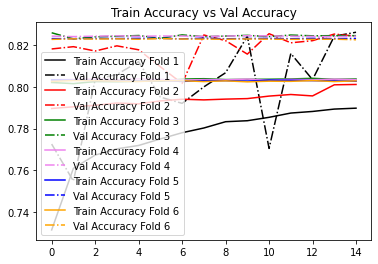

In [57]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='violet', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='violet', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='blue', linestyle = "dashdot")
plt.plot(model_history[5].history['accuracy'], label='Train Accuracy Fold 6', color='orange', )
plt.plot(model_history[5].history['val_accuracy'], label='Val Accuracy Fold 6', color='orange', linestyle = "dashdot")
plt.legend(loc="lower left")
plt.savefig("/content/gdrive/MyDrive/PROJECT/plots/trainVsVal_accM2.1.png")
plt.show()

## Classification Report for all folds

In [58]:
for i in range(n_folds):
  print(f"Fold {i+1}\n")
  print(clr)

Fold 1

              precision    recall  f1-score   support

        ANLS       0.84      0.18      0.29       446
          BD       0.60      0.09      0.16       388
         DoS       0.50      0.12      0.20      2725
         Exp       0.62      0.94      0.75      7421
        Fuzz       0.95      0.82      0.88      4041
         Gen       1.00      0.97      0.99      9812
       Recon       0.93      0.78      0.85      2331
        Shel       0.46      0.68      0.55       252
       Worms       0.75      0.10      0.18        29

    accuracy                           0.81     27445
   macro avg       0.74      0.52      0.54     27445
weighted avg       0.82      0.81      0.79     27445

Fold 2

              precision    recall  f1-score   support

        ANLS       0.84      0.18      0.29       446
          BD       0.60      0.09      0.16       388
         DoS       0.50      0.12      0.20      2725
         Exp       0.62      0.94      0.75      7421
        

## Draw Confusion Matrix

Fold 1



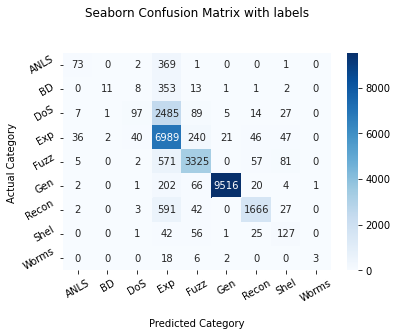

Fold 2



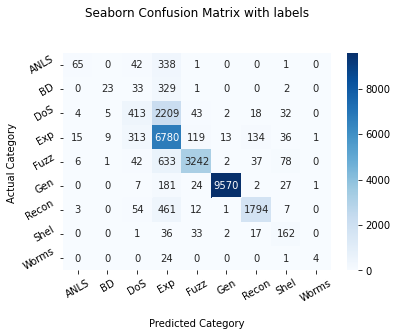

Fold 3



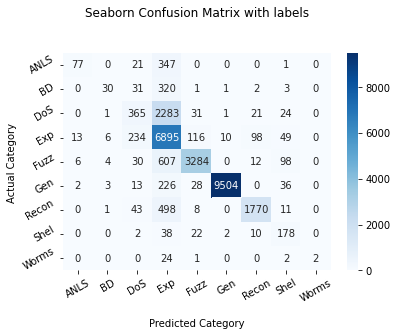

Fold 4



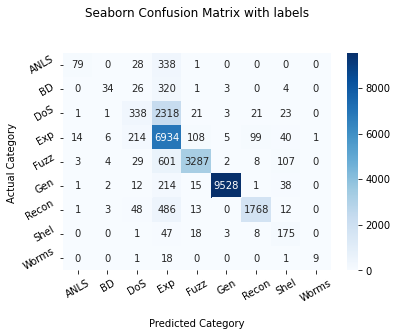

Fold 5



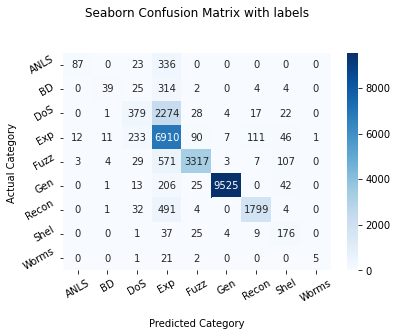

Fold 6



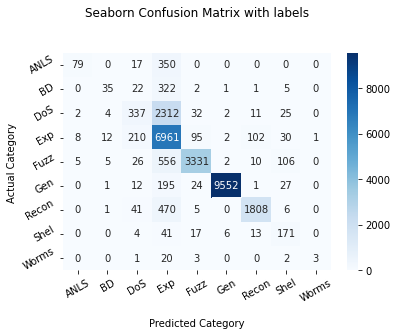

In [59]:
import seaborn as sns
for i in range(n_folds):
  print(f"Fold {i+1}\n")
  ax = sns.heatmap(cm_all[i], annot=True, cmap='Blues', fmt='d')
  
  ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Category')
  ax.set_ylabel('Actual Category ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'], rotation=30)
  ax.yaxis.set_ticklabels(['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'], rotation=30)

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [60]:
cnn.save('/content/gdrive/MyDrive/PROJECT/model_multi/CNN2.1.h5')

## Try 2 (Sigmoid (Sigmoid)

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='sigmoid',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='sigmoid',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='sigmoid',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='sigmoid',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
     
    layers.Flatten(),
    layers.Dense(32,activation='sigmoid'),
    layers.Dense(n_classes,activation='softmax'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 128
verbosity = 1

# Define per-fold score containers
model_history = []
clr=[]
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train],
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=verbosity,
              validation_split=0.2,
              callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    #y_preds1 = np.round(y_preds)
    y_preds_arg=np.argmax(y_preds, axis=1)

    clr = classification_report(y_array[test], y_preds_arg, target_names=['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'])
    cm= confusion_matrix(y_array[test],y_preds_arg)
    accuracy = accuracy_score(y_array[test], y_preds_arg)
    recall = recall_score(y_array[test], y_preds_arg, average='weighted')
    precision = precision_score(y_array[test], y_preds_arg, average='weighted')
    f1 = f1_score(y_array[test], y_preds_arg, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 41, 32)            128       
                                                                 
 conv1d_17 (Conv1D)          (None, 41, 32)            3104      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 20, 32)           0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 20, 32)            0         
                                                                 
 batch_normalization_8 (Batc  (None, 20, 32)           128       
 hNormalization)                                                 
                                                                 
 conv1d_18 (Conv1D)          (None, 20, 64)           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 12s 14ms/step - loss: 0.5767 - accuracy: 0.7799 - val_loss: 0.8927 - val_accuracy: 0.6770 - lr: 1.0000e-04
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5752 - accuracy: 0.7804 - val_loss: 0.8823 - val_accuracy: 0.6810 - lr: 1.0000e-04
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5749 - accuracy: 0.7797 - val_loss: 0.9012 - val_accuracy: 0.6762 - lr: 1.0000e-04
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5745 - accuracy: 0.7805 - val_loss: 0.8897 - val_accuracy: 0.6761 - lr: 1.0000e-04
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5733 - accuracy: 0.7812 - val_loss: 0.8495 - val_accuracy: 0.6856 - lr: 1.0000e-04
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5736 - accuracy: 0.7806 - val_loss: 0.8853 - val_accuracy: 0.6793 - lr: 1.0000e-04
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 12s 14ms/step - loss: 0.5702 - accuracy: 0.7809 - val_loss: 0.9197 - val_accuracy: 0.6692 - lr: 1.0000e-06
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5712 - accuracy: 0.7813 - val_loss: 0.9229 - val_accuracy: 0.6687 - lr: 1.0000e-06
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5705 - accuracy: 0.7810 - val_loss: 0.9170 - val_accuracy: 0.6700 - lr: 1.0000e-06
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5706 - accuracy: 0.7815 - val_loss: 0.9232 - val_accuracy: 0.6683 - lr: 1.0000e-06
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5703 - accuracy: 0.7809 - val_loss: 0.9163 - val_accuracy: 0.6698 - lr: 1.0000e-06
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5704 - accuracy: 0.7811 - val_loss: 0.9225 - val_accuracy: 0.6675 - lr: 1.0000e-06
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 12s 15ms/step - loss: 0.5689 - accuracy: 0.7821 - val_loss: 0.9217 - val_accuracy: 0.6663 - lr: 1.0000e-08
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5694 - accuracy: 0.7814 - val_loss: 0.9160 - val_accuracy: 0.6685 - lr: 1.0000e-08
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5688 - accuracy: 0.7819 - val_loss: 0.9205 - val_accuracy: 0.6666 - lr: 1.0000e-08
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5684 - accuracy: 0.7819 - val_loss: 0.9206 - val_accuracy: 0.6670 - lr: 1.0000e-08
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5693 - accuracy: 0.7820 - val_loss: 0.9208 - val_accuracy: 0.6669 - lr: 1.0000e-08
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5693 - accuracy: 0.7819 - val_loss: 0.9227 - val_accuracy: 0.6662 - lr: 1.0000e-08
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 12s 14ms/step - loss: 0.5680 - accuracy: 0.7821 - val_loss: 0.9250 - val_accuracy: 0.6645 - lr: 1.0000e-10
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5687 - accuracy: 0.7815 - val_loss: 0.9269 - val_accuracy: 0.6641 - lr: 1.0000e-10
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5687 - accuracy: 0.7823 - val_loss: 0.9294 - val_accuracy: 0.6636 - lr: 1.0000e-10
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5686 - accuracy: 0.7818 - val_loss: 0.9252 - val_accuracy: 0.6645 - lr: 1.0000e-10
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5685 - accuracy: 0.7829 - val_loss: 0.9253 - val_accuracy: 0.6644 - lr: 1.0000e-10
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5688 - accuracy: 0.7820 - val_loss: 0.9268 - val_accuracy: 0.6641 - lr: 1.0000e-10
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 12s 14ms/step - loss: 0.5692 - accuracy: 0.7815 - val_loss: 0.9188 - val_accuracy: 0.6680 - lr: 1.0000e-11
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5685 - accuracy: 0.7816 - val_loss: 0.9197 - val_accuracy: 0.6674 - lr: 1.0000e-11
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5684 - accuracy: 0.7815 - val_loss: 0.9190 - val_accuracy: 0.6674 - lr: 1.0000e-11
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5691 - accuracy: 0.7813 - val_loss: 0.9204 - val_accuracy: 0.6674 - lr: 1.0000e-11
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5684 - accuracy: 0.7820 - val_loss: 0.9150 - val_accuracy: 0.6682 - lr: 1.0000e-11
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.5693 - accuracy: 0.7810 - val_loss: 0.9184 - val_accuracy: 0.6679 - lr: 1.0000e-11
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 75.63215040443052 % - Loss: 0.6469405889511108 - Recall: 0.7563215040443052 - Precison: 0.7415001630258904 - f1_score: 0.718916219384377
------------------------------------------------------------------------
> Fold 2 - Accuracy: 75.807039277126 % - Loss: 0.6375377774238586 - Recall: 0.75807039277126 - Precison: 0.7436903374428284 - f1_score: 0.7231032957254357
------------------------------------------------------------------------
> Fold 3 - Accuracy: 76.29527071340087 % - Loss: 0.6245083808898926 - Recall: 0.7629527071340086 - Precison: 0.7587397975268109 - f1_score: 0.7286692293042449
------------------------------------------------------------------------
> Fold 4 - Accuracy: 76.14137365640372 % - Loss: 0.6287986040115356 - Recall: 0.7614137365640372 - Precison: 0.7517098780285812 - f1_score: 0.726831

Try 3 (Tanh)

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='tanh',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='tanh',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='tanh',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='tanh',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
     
    layers.Flatten(),
    layers.Dense(32,activation='tanh'),
    layers.Dense(n_classes,activation='softmax'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 128
verbosity = 1

# Define per-fold score containers
model_history = []
clr=[]
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train],
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=verbosity,
              validation_split=0.2,
              callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    #y_preds1 = np.round(y_preds)
    y_preds_arg=np.argmax(y_preds, axis=1)

    clr = classification_report(y_array[test], y_preds_arg, target_names=['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'])
    cm= confusion_matrix(y_array[test],y_preds_arg)
    accuracy = accuracy_score(y_array[test], y_preds_arg)
    recall = recall_score(y_array[test], y_preds_arg, average='weighted')
    precision = precision_score(y_array[test], y_preds_arg, average='weighted')
    f1 = f1_score(y_array[test], y_preds_arg, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 41, 32)            128       
                                                                 
 conv1d_21 (Conv1D)          (None, 41, 32)            3104      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 20, 32)           0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 20, 32)            0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_22 (Conv1D)          (None, 20, 64)           

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 77.06769656780588 % - Loss: 0.6080711483955383 - Recall: 0.7706769656780588 - Precison: 0.7684162347185969 - f1_score: 0.7373747732198065
------------------------------------------------------------------------
> Fold 2 - Accuracy: 77.73810391313852 % - Loss: 0.588905394077301 - Recall: 0.7773810391313852 - Precison: 0.7829166673811135 - f1_score: 0.7433393109313194
------------------------------------------------------------------------
> Fold 3 - Accuracy: 77.68345114042118 % - Loss: 0.587971031665802 - Recall: 0.7768345114042119 - Precison: 0.7936579294157943 - f1_score: 0.7426586132411719
------------------------------------------------------------------------
> Fold 4 - Accuracy: 77.8393149936236 % - Loss: 0.5889901518821716 - Recall: 0.7783931499362361 - Precison: 0.7892826337744515 - f1_score: 0.7442

Try 4 (LeakyReLU

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='LeakyReLU',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='LeakyReLU',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='LeakyReLU',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='LeakyReLU',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
     
    layers.Flatten(),
    layers.Dense(32,activation='LeakyReLU'),
    layers.Dense(n_classes,activation='softmax'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 128
verbosity = 1

# Define per-fold score containers
model_history = []
clr=[]
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train],
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=verbosity,
              validation_split=0.2,
              callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    #y_preds1 = np.round(y_preds)
    y_preds_arg=np.argmax(y_preds, axis=1)

    clr = classification_report(y_array[test], y_preds_arg, target_names=['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'])
    cm= confusion_matrix(y_array[test],y_preds_arg)
    accuracy = accuracy_score(y_array[test], y_preds_arg)
    recall = recall_score(y_array[test], y_preds_arg, average='weighted')
    precision = precision_score(y_array[test], y_preds_arg, average='weighted')
    f1 = f1_score(y_array[test], y_preds_arg, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 41, 32)            128       
                                                                 
 conv1d_29 (Conv1D)          (None, 41, 32)            3104      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 20, 32)           0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 20, 32)            0         
                                                                 
 batch_normalization_14 (Bat  (None, 20, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_30 (Conv1D)          (None, 20, 64)           

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 77.77089557676892 % - Loss: 0.590888500213623 - Recall: 0.7777089557676893 - Precison: 0.7779241656358895 - f1_score: 0.7475652473830425
------------------------------------------------------------------------
> Fold 2 - Accuracy: 77.75632150404431 % - Loss: 0.580907940864563 - Recall: 0.777563215040443 - Precison: 0.7781892878474431 - f1_score: 0.7485712011093162
------------------------------------------------------------------------
> Fold 3 - Accuracy: 77.9712890767325 % - Loss: 0.5743858218193054 - Recall: 0.779712890767325 - Precison: 0.7765817320304178 - f1_score: 0.7496188798886108
------------------------------------------------------------------------
> Fold 4 - Accuracy: 77.89761340863546 % - Loss: 0.575570821762085 - Recall: 0.7789761340863546 - Precison: 0.7747404905119082 - f1_score: 0.7484250

Try 5 (SOftmax)

In [ ]:
cnn = models.Sequential([
    layers.Conv1D(32,3,activation='softmax',padding='same', kernel_initializer='he_uniform', input_shape = (41, 1)),
    layers.Conv1D(32,3,activation='softmax',padding='same',kernel_initializer='he_uniform'),
    layers.MaxPooling1D(pool_size=2,strides=2),
    layers.Dropout(0.002),
    layers.BatchNormalization(),
    
    layers.Conv1D(64,3,activation='softmax',padding='same',kernel_initializer='he_uniform'),
    layers.Conv1D(64,3,activation='softmax',padding='same',kernel_initializer='he_uniform'), 
    layers.MaxPooling1D(pool_size=2,strides=2), 
    layers.Dropout(0.002),
    layers.BatchNormalization(),   
     
    layers.Flatten(),
    layers.Dense(32,activation='softmax'),
    layers.Dense(n_classes,activation='softmax'),   #UNSW-NB15 is 2 and 10,CICIDS2017 is 15
])

cnn.summary()

# Compile the model
optimizer = 'Nadam'
nadam =optimizers.Nadam(learning_rate = 0.008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
cnn.compile(optimizer="nadam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the K-fold Cross Validator
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

n_epochs = 15
batch_size = 128
verbosity = 1

# Define per-fold score containers
model_history = []
clr=[]
cm_all=[]
acc_all=[]
loss_all=[]
recall_all=[]
precision_all=[]
f1_all=[]

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=5)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(x_3d, y_array):

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = cnn.fit(x_3d[train], y_array[train],
              batch_size=batch_size,
              epochs=n_epochs,
              verbose=verbosity,
              validation_split=0.2,
              callbacks = [reduce_lr])

    # Generate generalization metrics
    scores = cnn.evaluate(x_3d[test], y_array[test], verbose=0)
    print(f'\nScore for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100} %')

    y_preds = cnn.predict(x_3d[test])
    #y_preds1 = np.round(y_preds)
    y_preds_arg=np.argmax(y_preds, axis=1)

    clr = classification_report(y_array[test], y_preds_arg, target_names=['ANLS','BD','DoS','Exp','Fuzz','Gen','Recon','Shel','Worms'])
    cm= confusion_matrix(y_array[test],y_preds_arg)
    accuracy = accuracy_score(y_array[test], y_preds_arg)
    recall = recall_score(y_array[test], y_preds_arg, average='weighted')
    precision = precision_score(y_array[test], y_preds_arg, average='weighted')
    f1 = f1_score(y_array[test], y_preds_arg, average='weighted')
    

    model_history.append(history)
    cm_all.append(cm)
    acc_all.append(accuracy * 100)
    loss_all.append(scores[0])
    recall_all.append(recall)
    precision_all.append(precision)
    f1_all.append(f1)

    fold_no += 1

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 41, 32)            128       
                                                                 
 conv1d_33 (Conv1D)          (None, 41, 32)            3104      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 20, 32)           0         
 g1D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 20, 32)            0         
                                                                 
 batch_normalization_16 (Bat  (None, 20, 32)           128       
 chNormalization)                                                
                                                                 
 conv1d_34 (Conv1D)          (None, 20, 64)           

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 12s 14ms/step - loss: 0.6700 - accuracy: 0.7609 - val_loss: 1.3480 - val_accuracy: 0.6390 - lr: 1.0000e-05
Epoch 2/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6698 - accuracy: 0.7611 - val_loss: 1.3274 - val_accuracy: 0.6446 - lr: 1.0000e-05
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6684 - accuracy: 0.7608 - val_loss: 1.3357 - val_accuracy: 0.6413 - lr: 1.0000e-05
Epoch 4/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6691 - accuracy: 0.7608 - val_loss: 1.3326 - val_accuracy: 0.6408 - lr: 1.0000e-05
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6693 - accuracy: 0.7598 - val_loss: 1.3347 - val_accuracy: 0.6408 - lr: 1.0000e-05
Epoch 6/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6694 - accuracy: 0.7602 - val_loss: 1.3216 - val_accuracy: 0.6487 - lr: 1.0000e-05
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 13s 15ms/step - loss: 0.6689 - accuracy: 0.7609 - val_loss: 1.3406 - val_accuracy: 0.6424 - lr: 1.0000e-06
Epoch 2/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6679 - accuracy: 0.7618 - val_loss: 1.3335 - val_accuracy: 0.6430 - lr: 1.0000e-06
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6687 - accuracy: 0.7614 - val_loss: 1.3334 - val_accuracy: 0.6428 - lr: 1.0000e-06
Epoch 4/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6681 - accuracy: 0.7625 - val_loss: 1.3346 - val_accuracy: 0.6427 - lr: 1.0000e-06
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6672 - accuracy: 0.7618 - val_loss: 1.3305 - val_accuracy: 0.6434 - lr: 1.0000e-06
Epoch 6/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6686 - accuracy: 0.7613 - val_loss: 1.3342 - val_accuracy: 0.6428 - lr: 1.0000e-06
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 13s 15ms/step - loss: 0.6683 - accuracy: 0.7618 - val_loss: 1.3338 - val_accuracy: 0.6422 - lr: 1.0000e-06
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6686 - accuracy: 0.7615 - val_loss: 1.3355 - val_accuracy: 0.6420 - lr: 1.0000e-06
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6692 - accuracy: 0.7614 - val_loss: 1.3399 - val_accuracy: 0.6415 - lr: 1.0000e-06
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6688 - accuracy: 0.7610 - val_loss: 1.3336 - val_accuracy: 0.6443 - lr: 1.0000e-06
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6694 - accuracy: 0.7604 - val_loss: 1.3387 - val_accuracy: 0.6414 - lr: 1.0000e-06
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6683 - accuracy: 0.7618 - val_loss: 1.3405 - val_accuracy: 0.6415 - lr: 1.0000e-06
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 13s 15ms/step - loss: 0.6709 - accuracy: 0.7615 - val_loss: 1.3190 - val_accuracy: 0.6449 - lr: 1.0000e-08
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6711 - accuracy: 0.7612 - val_loss: 1.3243 - val_accuracy: 0.6445 - lr: 1.0000e-08
Epoch 3/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6710 - accuracy: 0.7615 - val_loss: 1.3216 - val_accuracy: 0.6447 - lr: 1.0000e-08
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6700 - accuracy: 0.7606 - val_loss: 1.3220 - val_accuracy: 0.6446 - lr: 1.0000e-08
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6705 - accuracy: 0.7616 - val_loss: 1.3254 - val_accuracy: 0.6443 - lr: 1.0000e-08
Epoch 6/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6705 - accuracy: 0.7613 - val_loss: 1.3192 - val_accuracy: 0.6451 - lr: 1.0000e-08
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

858/858 [==============================] - 13s 15ms/step - loss: 0.6691 - accuracy: 0.7617 - val_loss: 1.3336 - val_accuracy: 0.6416 - lr: 1.0000e-10
Epoch 2/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6693 - accuracy: 0.7612 - val_loss: 1.3255 - val_accuracy: 0.6457 - lr: 1.0000e-10
Epoch 3/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6692 - accuracy: 0.7615 - val_loss: 1.3285 - val_accuracy: 0.6416 - lr: 1.0000e-10
Epoch 4/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6684 - accuracy: 0.7619 - val_loss: 1.3268 - val_accuracy: 0.6420 - lr: 1.0000e-10
Epoch 5/15
858/858 [==============================] - 12s 14ms/step - loss: 0.6688 - accuracy: 0.7616 - val_loss: 1.3293 - val_accuracy: 0.6417 - lr: 1.0000e-10
Epoch 6/15
858/858 [==============================] - 13s 15ms/step - loss: 0.6687 - accuracy: 0.7612 - val_loss: 1.3305 - val_accuracy: 0.6417 - lr: 1.0000e-10
Epoch 7/15
858/858 [=========================

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_all)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Accuracy: {acc_all[i]} % - Loss: {loss_all[i]} - Recall: {recall_all[i]} - Precison: {precision_all[i]} - f1_score: {f1_all[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_all)} % (+- {np.std(acc_all)})')
print(f'> Loss: {np.mean(loss_all)}')
print(f'> Recall: {np.mean(recall_all)}')
print(f'> Precision: {np.mean(precision_all)}')
print(f'> F1-Score: {np.mean(f1_all)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Accuracy: 73.54077096844713 % - Loss: 0.8073222041130066 - Recall: 0.7354077096844713 - Precison: 0.7066771815639079 - f1_score: 0.7079610928036218
------------------------------------------------------------------------
> Fold 2 - Accuracy: 73.93427093201194 % - Loss: 0.7992533445358276 - Recall: 0.7393427093201195 - Precison: 0.7138102626877776 - f1_score: 0.7080148984941612
------------------------------------------------------------------------
> Fold 3 - Accuracy: 74.23303942286672 % - Loss: 0.79206782579422 - Recall: 0.7423303942286672 - Precison: 0.7191007285137776 - f1_score: 0.7127854446888355
------------------------------------------------------------------------
> Fold 4 - Accuracy: 74.4142831116779 % - Loss: 0.7841236591339111 - Recall: 0.744142831116779 - Precison: 0.7190431307705459 - f1_score: 0.71430